# Human facial expression recognition

I am going to build a CNN to detect humans facial expressions from this [Kaggle dataset](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge), let's follow some steps:

1. Data analysis
2. Data preprocessing
3. Build CNN model
4. Investigate unbalanced dataset issues

Published by Joao Pedro dos Santos

Critiqued by Joshua Brewington and Johnny Duenas

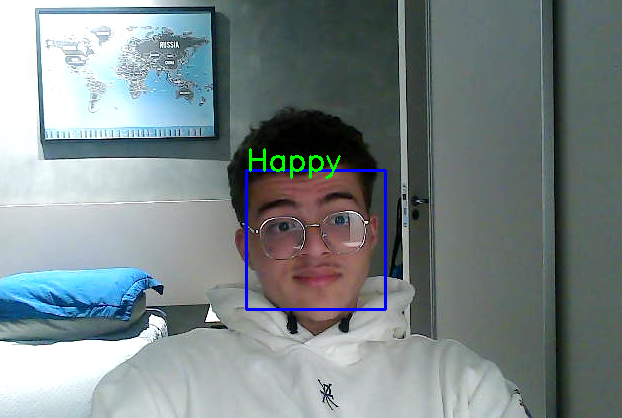

## 1. Data analysis

This is our model with the 4 highest amount of frequencies. We wanted to test the accuracy differences when using the highest frequencies amongst the samples.

In [ ]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import cv2
import os

Below is how to access the data folder when the session is running. The DATA.zip file must be uploaded manually to the session folder and placed in the content folder for the data to properly load.

In [ ]:
import os
import zipfile

# Step 1: Upload the DATA.zip file using Colab's file upload feature

# Step 2: Unzip the file
zip_path = '/content/DATA.zip'  # Adjust if your path is different
unzip_folder = '/content/unzipped_data'  # Folder to extract to
os.makedirs(unzip_folder, exist_ok=True)  # Create the folder if it doesn't exist

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_folder)

# Step 3: Load the CSV file into a DataFrame
csv_file_path = '/content/unzipped_data/DATA/Reduced_fer20131.csv'  # Adjust the path if necessary
data = pd.read_csv(csv_file_path)

# Step 4: Print the first few rows of the DataFrame
print(data.head())

   emotion                                             pixels        Usage
0        0  232 232 232 232 230 229 209 192 183 163 178 20...  PrivateTest
1        0  231 234 238 235 239 226 118 35 16 7 7 20 9 8 3...     Training
2        0  109 76 85 77 57 34 58 60 46 39 47 31 11 26 42 ...  PrivateTest
3        0  6 7 10 11 10 14 20 27 30 36 57 79 97 108 100 9...     Training
4        0  147 148 148 149 149 149 150 151 151 152 152 15...     Training


The code below is used to drop the classes via index positions of the classes.

In [ ]:
# Keep only classes 3, 6, 4, and 2
data = data[data["emotion"].isin([3, 6, 4, 2])]

# Remap the 'emotion' labels to be continuous starting from 0
# The new mapping will be {3: 0, 6: 1, 4: 2, 2: 3}
new_labels = {3: 0, 6: 1, 4: 2, 2: 3}
data["emotion"] = data["emotion"].map(new_labels)

In [ ]:
# Dictionary of class names
class_names = ["Happy", "Neutral", "Sad", "Fear"]


In [ ]:
def plot_data(data, classes):

  values = data["emotion"].value_counts().sort_index(ascending=True)
  colors = ["lightgreen", "blue", "lightblue", "pink"]

  plt.figure(figsize=[12, 5])

  plt.bar(x=classes, height=values, color=colors, edgecolor='black')

  plt.xlabel("Emotions")
  plt.ylabel("Amount")
  plt.title("Amount of emotions for 4 Highest Classes")
  plt.show();

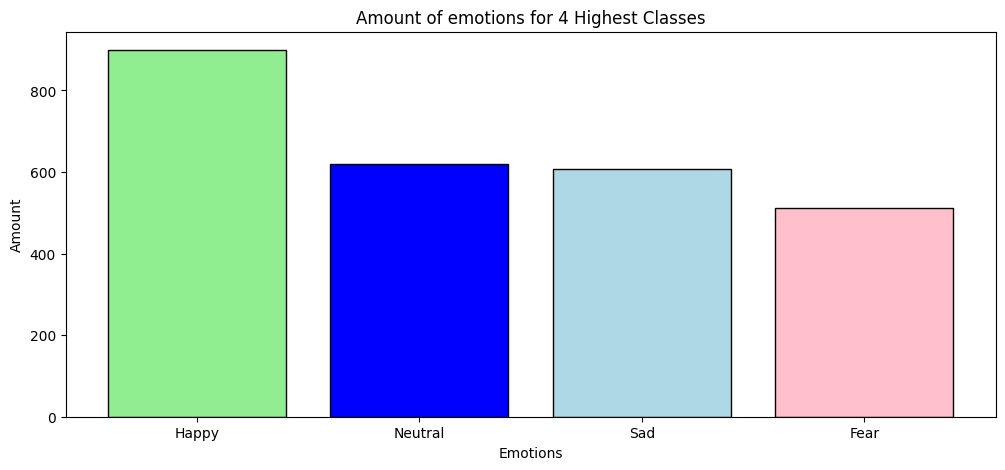

In [ ]:
plot_data(data, class_names)

This graph displays the four Highest classes.

In [ ]:
# Functions for data preprocessing
def pixels_to_array(pixels):
    array = np.array(pixels.split(), 'float64')
    return array

def image_reshape(data):
    image = np.reshape(data.to_list(), (data.shape[0], 48, 48, 1))
    image = np.repeat(image, 3, -1)
    return image



## Data Preprocessing

Here we copied the dataset and stored it in a new dataframe. From here it made it easier to manipulate and coverts the data into an array of pixel values. The data is then split into test and training sets in a format that is required by the model.

In [ ]:
# Apply preprocessing
df = data.copy()
df['pixels'] = df["pixels"].apply(pixels_to_array)
data_train = df[df["Usage"] == "Training"]
data_test1 = df[df["Usage"] == "PublicTest"]
data_test2 = df[df["Usage"] == "PrivateTest"]
data_test = pd.concat([data_test1, data_test2])
X_train = image_reshape(data_train["pixels"])
X_test = image_reshape(data_test["pixels"])
y_train = data_train["emotion"]
y_test = data_test["emotion"]



This sets up a Directory in the session folder for the data.

In [ ]:
# Directory setup for data
!mkdir -p data/train
!mkdir -p data/test



This puts the images in their directories that were created in the cell above.

In [ ]:
# Put images in their respective directories
def put_in_dir(X, y, classes, usage):
    for label in range(len(classes)):
        os.makedirs(f"/content/data/{usage}/" + classes[label], exist_ok=True)

    for i in range(len(X)):
        emotion = classes[y.iloc[i]]
        cv2.imwrite(f"/content/data/{usage}/{emotion}/{emotion}{i}.png", X[i])

put_in_dir(X_train, y_train, class_names, "train")
put_in_dir(X_test, y_test, class_names, "test")


## Data Augmentation and Preparation

Below the code is preparing and augmenting image data for training and testing in our CNN model. The training data is undergoing augmentation to introduce variability, which helps generalize the model while the test data is rescaled.

## ImageDataGenerator

This is a class in Keras that is used for efficient and effective image data preprocessing and augmentation.

In [ ]:
#This imports the 'ImageGenerator' class
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (48, 48)  # The image shape is set ot 48x48 pixels
BATCH_SIZE = 32   # The batch will contain 32 images

# Strings that go to file paths corresponding to the training and testing directories
train_dir = "/content/data/train/"
test_dir =  "/content/data/test/"

# Instances of the 'ImageGenerator' class and data augmentation parameters
# Rescales the image between 0 and 1 pixel values
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.5,
                                   zoom_range=0.5)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir, # Flow_from_directory loads images from the directory from train_dir to resize them to Image_shape adn then returns them to batches
                                                target_size=IMAGE_SHAPE,
                                                batch_size=BATCH_SIZE,
                                                class_mode="categorical",
                                                # shuffle=True,
                                                save_to_dir=train_dir,
                                               save_prefix="N",
                                               save_format="jpg")


test_data = test_datagen.flow_from_directory(test_dir,  # Creates data generator for the test data and load images from 'test_dir', then resizes them and returns them to batches
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 2086 images belonging to 4 classes.
Found 553 images belonging to 4 classes.


## Building a CNN Model

We made sure to adjust the Dense layer to accomade 4 classes. Yet, again we used the 4 highest classes.

In [ ]:
# Build CNN model
tf.random.set_seed(42)

model_1 = Sequential([
  Input(shape=(48, 48, 3)),
  Conv2D(512, (3,3), activation="relu", padding="same"),
  BatchNormalization(),
  Conv2D(256, (3,3), activation="relu", padding="same"),
  BatchNormalization(),
  MaxPool2D(2),
  Dropout(0.5),
  Conv2D(128, (3,3), activation="relu", padding="same"),
  BatchNormalization(),
  Conv2D(64, (3,3), activation="relu", padding="same"),
  BatchNormalization(),
  MaxPool2D(2),
  Dropout(0.5),
  Conv2D(32, (3,3), activation="relu", padding="same"),
  MaxPool2D(2),
  Dropout(0.5),
  Flatten(),
  Dense(4, activation="softmax")  # Output layer for 4 classes
])

# Compile and fit the model
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

checkpoint_callback = ModelCheckpoint(filepath="checkpoint/", save_weights_only=False, save_best_only=True, save_freq="epoch", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=8, min_lr=0.00001)

history = model_1.fit(train_data, epochs=45, callbacks=[reduce_lr, checkpoint_callback], validation_data=test_data)

Epoch 1/45
 7/66 [==>...........................] - ETA: 10:46 - loss: 4.7632 - accuracy: 0.3259

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history.history['loss'], color=color, label='Train Loss')
ax1.plot(history.history['val_loss'], color=color, linestyle='dashed', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(history.history['accuracy'], color=color, label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], color=color, linestyle='dashed', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Model Accuracy and Loss')
plt.show()


The training loss rapidly decreases and then plateaus at 0.25 which suggests that the model is adequately learning. The validation loss suggests there was no rapid decrease but instead had a general plateau at around 0.25 with little fluctuation. Training accuracy steadily improves right below the validation accuracy dashed line right at the 10th epoch and doesnâ€™t show behaviors of plateauing. The validation accuracy had a rapid increase and gradually improved but plateaus at an accuracy around 0.45 which can suggest that the model has reached its peak performance with the architecture we gave it. The significance of these trends suggests that there was overfitting of data considering the fluctuating trends of the training and validation accuracy followed by the lack of diverse trends from the four highest classes pertaining to validation and training loss.


In [ ]:
# Save the model
#model_1.save("model.h5")
#!zip -r /content/file.zip /content/checkpoint